In [12]:
import torch
from modules import SConv2d, SLinear, SModel, SReLU
from models import SCrossEntropyLoss
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def CECross(output):
    BS = output.shape[0]
    e3 = (output - output.max()).exp()
    e3_sum = e3.sum(dim=1).unsqueeze(1).expand_as(e3)
    ratio = (e3 / e3_sum).view(BS,1,-1)
    return (torch.diag_embed(ratio.view(BS,-1),0,1) - ratio.swapaxes(1,2).bmm(ratio))

def crossSecond(IN, outS):
    BS = IN.shape[0]
    IN = IN.view(BS,1,-1)
    return IN.swapaxes(1,2).bmm(IN).view(BS,-1).t().mm(outS.view(BS,-1)).view(3,3,3,3).swapaxes(0,2).swapaxes(0,1).reshape(9,9)

In [29]:
 correct1 = []
 correct2 = []
 calc1 = []
 calc2 = []

 for _ in tqdm(range(100)):
    fc1 = SLinear(3,3,bias=False)
    # fc1.op.weight.data = torch.Tensor(list(range(1,10))).view(fc1.op.weight.shape) * 0.1
    # fc1.op.bias.data = torch.zeros_like(fc1.op.bias)
    fc2 = SLinear(3,3,bias=False)
    # fc2.op.weight.data = torch.Tensor(list(range(9,0,-1))).view(fc2.op.weight.shape) * 0.1
    # fc2.op.weight.data[0,0] = 2
    # fc2.op.bias.data = torch.zeros_like(fc2.op.bias)
    relu = SReLU()
    criteria = SCrossEntropyLoss()
    optimizer = torch.optim.SGD(list(fc1.parameters()) + list(fc2.parameters()), 1e-1)

    for _ in range(1000):
        optimizer.zero_grad()
        x = torch.Tensor([[1,2,3]])
        xS = torch.zeros_like(x)
        labels = torch.LongTensor([0])

        x1, xS1 = fc1(x, xS)
        x1.retain_grad()
        xS1.retain_grad()
        x2, xS2 = relu(x1, xS1)
        x2.retain_grad()
        xS2.retain_grad()
        x3, xS3 = fc2(x2, xS2)
        x3.retain_grad()
        xS3.retain_grad()

        loss = criteria(x3, xS3, labels)
        loss.backward()
        optimizer.step()

    optimizer = torch.optim.SGD(list(fc1.parameters()) + list(fc2.parameters()), 0)
    optimizer.zero_grad()
    x = torch.Tensor([[1,2,3]])
    xS = torch.zeros_like(x)
    labels = torch.LongTensor([0])

    x1, xS1 = fc1(x, xS)
    x1.retain_grad()
    xS1.retain_grad()
    x2, xS2 = relu(x1, xS1)
    x2.retain_grad()
    xS2.retain_grad()
    x3, xS3 = fc2(x2, xS2)
    x3.retain_grad()
    xS3.retain_grad()

    loss = criteria(x3, xS3, labels)
    if loss < 1e-3:
        loss.backward()
        optimizer.step()
        x3SG = CECross(x3)
        mask = (x2 == 0).to(torch.float)
        x1SG = fc2.op.weight.t().matmul(x3SG * mask).matmul(fc2.op.weight)
        fc1WSG = crossSecond(x,  x1SG)
        fc2WSG = crossSecond(x2, x3SG)
        correct1 += fc1WSG.view(9,9).diag().data.numpy().tolist()
        correct2 += fc2WSG.view(9,9).diag().data.numpy().tolist()
        calc1 += fc1.weightS.grad.view(-1).data.numpy().tolist()
        calc2 += fc2.weightS.grad.view(-1).data.numpy().tolist()

In [44]:
# x3SG = torch.Tensor([[0.0123928,-0.0117341,-0.000658689,-0.0117341,0.011742,-7.92681E-6,-0.000658689,-7.92681E-6,0.000666616]]).view(1,3,3)
# x1SG = torch.Tensor([[0.0249031,0.00560088,0.00560088,0.00560088,0.00129391,0.00129391,0.00560088,0.00129391,0.00129391]]).view(1,3,3)

(-0.001, 0.005)

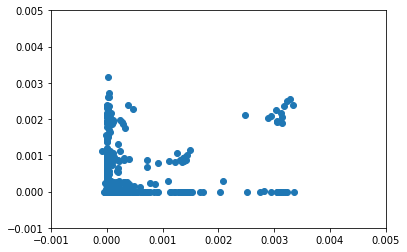

In [30]:
plt.scatter(correct1, calc1)
plt.xlim(-0.001, 0.005)
plt.ylim(-0.001, 0.005)

(-0.001, 0.005)

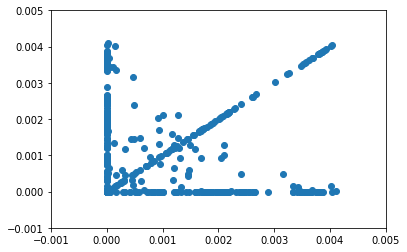

In [31]:
plt.scatter(correct2, calc2)
plt.xlim(-0.001, 0.005)
plt.ylim(-0.001, 0.005)

In [40]:
fc1 = SLinear(3,3,bias=False)
# fc1.op.weight.data = torch.Tensor(list(range(1,10))).view(fc1.op.weight.shape) * 0.1
# fc1.op.bias.data = torch.zeros_like(fc1.op.bias)
fc2 = SLinear(3,3,bias=False)
# fc2.op.weight.data = torch.Tensor(list(range(9,0,-1))).view(fc2.op.weight.shape) * 0.1
# fc2.op.weight.data[0,0] = 2
# fc2.op.bias.data = torch.zeros_like(fc2.op.bias)
relu = SReLU()
criteria = SCrossEntropyLoss()
optimizer = torch.optim.SGD(list(fc1.parameters()) + list(fc2.parameters()), 1e-1)

for _ in range(1000):
    optimizer.zero_grad()
    x = torch.Tensor([[1,2,3]])
    xS = torch.zeros_like(x)
    labels = torch.LongTensor([0])

    x1, xS1 = fc1(x, xS)
    x1.retain_grad()
    xS1.retain_grad()
    x2, xS2 = relu(x1, xS1)
    x2.retain_grad()
    xS2.retain_grad()
    x3, xS3 = fc2(x2, xS2)
    x3.retain_grad()
    xS3.retain_grad()

    loss = criteria(x3, xS3, labels)
    loss.backward()
    optimizer.step()

optimizer = torch.optim.SGD(list(fc1.parameters()) + list(fc2.parameters()), 0)
optimizer.zero_grad()
x = torch.Tensor([[1,2,3]])
xS = torch.zeros_like(x)
labels = torch.LongTensor([0])

x1, xS1 = fc1(x, xS)
x1.retain_grad()
xS1.retain_grad()
x2, xS2 = relu(x1, xS1)
x2.retain_grad()
xS2.retain_grad()
x3, xS3 = fc2(x2, xS2)
x3.retain_grad()
xS3.retain_grad()

loss = criteria(x3, xS3, labels)
if loss < 1e-3:
    loss.backward()

In [41]:
loss

tensor(0.0001, grad_fn=<SCrossEntropyLossFunctionBackward>)

In [42]:
xS3.grad

tensor([[1.2790e-04, 5.2293e-05, 7.5599e-05]])

In [45]:
CECross(x3).view(3,3).diag()

tensor([1.2791e-04, 5.2293e-05, 7.5599e-05], grad_fn=<DiagBackward>)